### Hypotheses
- [Lower ripple rate during SD compared NSD](#ripple_rate): One possibility of faster decay of replay during sleep deprivation could be reduced ripple rate at the beginning of POST. This may suggest that in order for cells to replay they need sufficient number/amount of elicitation to last for certain duration of time, so a lower ripple rate could interrupt this requirement.


### Detecting noisy ripples using PCA/KMeans
- Since faster-oscillation artifacts have power in ripple band, these may get picked up during ripple detection based on hilbert transform. These ripple-like artifacts can possibly be eliminated using clustering algorithms.  

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from neuropy.plotting import Fig
import pandas as pd
from scipy import stats
import subjects

sessions = subjects.sd.ratNday1

In [2]:
from neuropy.utils.signal_process import hilbertfast, filter_sig
from sklearn.decomposition import PCA

for sub, sess in enumerate(sessions):
    good_chans = np.concatenate(sess.probegroup.get_connected_channels())
    pca_ripples = []
    for i in range(len(sess.ripple)):
        rpls = sess.ripple[i].flatten()
        signal = sess.eegfile.get_signal(good_chans.astype("int"), rpls[0], rpls[1])
        hilbert_amp = np.abs(
            hilbertfast(filter_sig.bandpass(signal.traces, lf=130, hf=250, ax=-1), ax=1)
        )

        pca = PCA(n_components=1).fit_transform(hilbert_amp)
        pca_ripples.append(pca.reshape(-1))
pca_ripples = np.asarray(pca_ripples)

In [3]:
from sklearn.cluster import KMeans,DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler
from neuropy.core import Epoch
from sklearn.neighbors import LocalOutlierFactor


pca_of_rpl_amp = PCA(n_components=2).fit_transform(pca_ripples)
features = MinMaxScaler().fit_transform(pca_of_rpl_amp) 
labels = GaussianMixture(n_components=2,random_state=0).fit_predict(features)
outliers= LocalOutlierFactor(n_neighbors=20).fit_predict(features)

# starts,stops = sess.ripple.starts,sess.ripple.stops
# weird_ripples = Epoch.from_array(starts[labels==0],stops[labels==0])
# sess.recinfo.write_epochs(weird_ripples,ext='wrp')


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
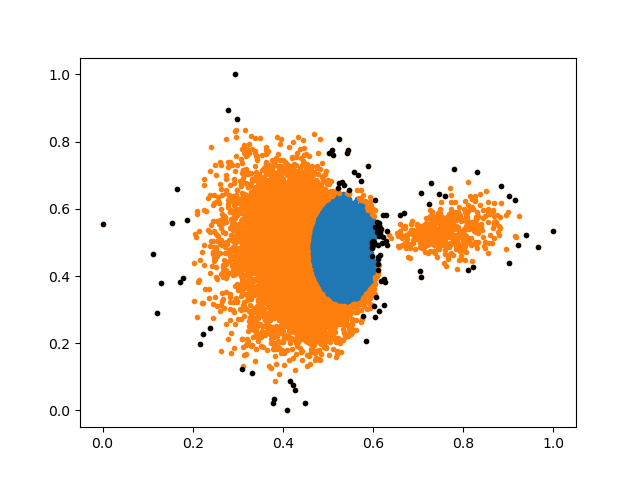

In [4]:
%matplotlib widget

for l in [0,1]:
    plt.plot(features[labels==l,0],features[labels==l,1],'.')

plt.plot(features[outliers==-1,0],features[outliers==-1,1],'k.')

### Ripple power spectrum comaprison 1st vs 5th hour
- To see if ripple lfp timeseries changes PSD during sleep deprivation and compare it to NSD
- Method: Ripple traces are concatenated in their corresponding hour and then a PSD is calculated
- Results: Compared to 1st hour, ripple band in 5th hour shows a little shift towards lower frequencies (maybe the start cutoff for ripple band is only changing)

In [46]:
import matplotlib.pyplot as plt
from neuropy.utils.signal_process import TimeFrequency
import numpy as np
from neuropy.plotting import Fig
import pandas as pd
from scipy import stats
import subjects

sessions = (
    subjects.sd.ratJday1
    + subjects.sd.ratKday1
    +subjects.sd.ratNday1
    + subjects.sd.ratSday3
    + subjects.sd.ratRday2
    + subjects.sd.ratUday4
    + subjects.sd.ratVday2
    +subjects.nsd.ratJday2
    + subjects.nsd.ratKday2
    + subjects.nsd.ratNday2
    + subjects.nsd.ratSday2
    + subjects.nsd.ratRday1
    + subjects.nsd.ratUday2
    + subjects.nsd.ratVday1
)

rpl_channels = [39,63,111,95,49,100,85,63,63,36,188,32,86,86]

In [47]:
import scipy.signal as sg

psd_rpl_df = pd.DataFrame()
for sub, sess in enumerate(sessions):
    post = sess.paradigm["post"].flatten()
    rpl_chan = sess.ripple.metadata["channels"][2]

    psd = []
    for t in [post[0], post[0] + 4 * 3600]:
        signal = sess.eegfile.get_signal(rpl_chan, t, t + 3600)
        rpl_t = sess.ripple.time_slice(t, t + 3600).as_array()
        rpl_frames = [np.arange(int(e[0] * 1250), int(e[1] * 1250)) for e in rpl_t]
        rpl_frames = np.concatenate(rpl_frames) - int(t * 1250)
        rpl_frames = rpl_frames[rpl_frames<signal.n_frames]
        psd.append(
            sg.welch(signal.traces[0][rpl_frames], fs=1250, nperseg=1250, noverlap=625)
        )

    psd_rpl_df = psd_rpl_df.append(
        pd.DataFrame(
            {
                "freq": psd[0][0],
                "zt1": psd[0][1],
                "zt5": psd[1][1],
                "sub": sub,
                "grp": sess.tag,
            }
        ),
        ignore_index=True,
    )

psd_rpl_df= pd.melt(
    psd_rpl_df,
    id_vars=["grp", "sub",'freq'],
    value_vars=['zt1','zt5'],
    var_name=["hour"],
    value_name="psd",
    ignore_index=True,
)

[(90, 350), (90, 350)]

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
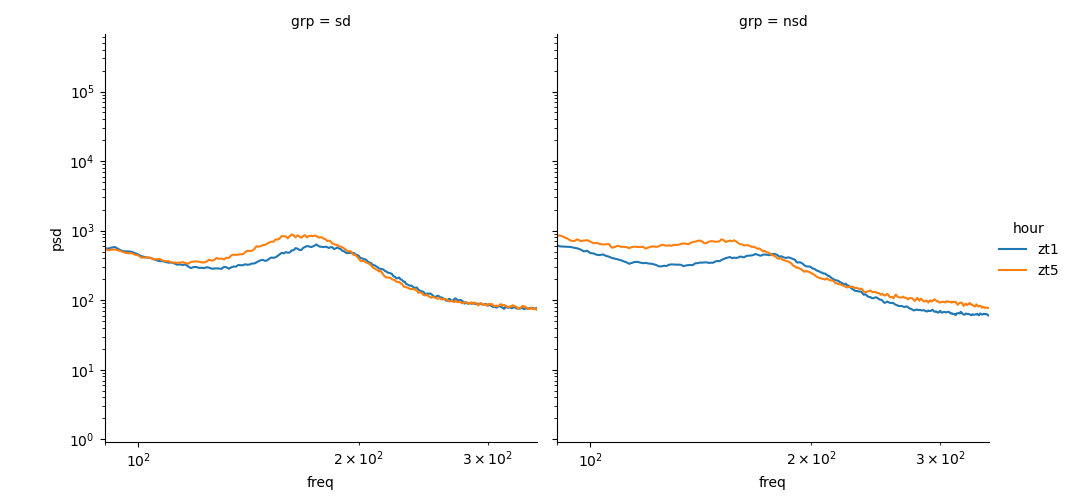

In [51]:
%matplotlib widget
import seaborn as sns

g = sns.relplot(
    data=psd_rpl_df,
    x="freq",
    y="psd",
    hue="hour",
    col="grp",
    kind="line",
    col_wrap=2,
    # facet_kws={"sharex": False, "sharey": False},
    ci=None,
)

[ax.set(xscale='log',yscale='log') for ax in g.axes]
[ax.set_xlim([90,350]) for ax in g.axes]


### Frequency and power distribution comparison between 1st and 5th hour of POST 
- both measures were calculated using wavelet transform
- Runs slow, maybe adding parallel loop for wavelet calculation will help, or move to hilbert amplitude which will be lot faster.
- **Results**: Hardly any changes to ripple power or frequency observed during sleep deprivation or recovery sleep

In [1]:
import matplotlib.pyplot as plt
from neuropy.utils.signal_process import TimeFrequency
import numpy as np
from neuropy.plotting import Fig
import pandas as pd
from scipy import stats
import subjects

sessions = (
    subjects.sd.ratJday1
    + subjects.sd.ratKday1
    + subjects.sd.ratNday1
    + subjects.sd.ratSday3
    + subjects.sd.ratRday2
    + subjects.sd.ratUday4
    + subjects.sd.ratVday2
    + subjects.nsd.ratJday2
    + subjects.nsd.ratKday2
    + subjects.nsd.ratNday2
    + subjects.nsd.ratSday2
    + subjects.nsd.ratRday1
    + subjects.nsd.ratUday2
    + subjects.nsd.ratVday1
)


In [ ]:
from neuropy.utils.signal_process import hilbert_ampltiude_stat

rpl_power = pd.DataFrame()
rpl_freq_dist = pd.DataFrame()

for sub, sess in enumerate(sessions):
    print(sess.tag, sub)
    post = sess.paradigm["post"].flatten()
    # sd = sess.paradigm["sd"].flatten()
    sd = [post[0], post[0] + 5 * 3600]
    channels = sess.ripple.metadata["channels"]

    signal = sess.eegfile.get_signal(channels, 1800, 3600)
    hilbert_stat = hilbert_ampltiude_stat(
        signal.traces, freq_band=(150, 250), fs=1250, statistic="median"
    )

    channel = channels[np.argmax(hilbert_stat)]

    freqs = np.arange(130, 250, 2)
    rpls_1h = sess.ripple.time_slice(sd[0], sd[0] + 3600).set_labels("1st")
    rpls_5h = sess.ripple.time_slice(sd[0] + 4 * 3600, sd[1]).set_labels("5th")
    rpls_6h = sess.ripple.time_slice(sd[1], sd[1] + 3600).set_labels("6th")

    rpls_comb = rpls_1h + rpls_5h + rpls_6h
    max_power, freq_dist = [], []
    for start, stop in zip(rpls_comb.starts, rpls_comb.stops):
        signal = sess.eegfile.get_signal(channel, start, stop)
        wvlt = TimeFrequency(signal=signal, freqs=freqs, method="wavelet", ncycles=7)
        wvlt_mean = wvlt.mean_power()
        max_power.append(np.max(wvlt_mean))
        freq_dist.append(np.mean(wvlt.traces, axis=1))

    df1 = pd.DataFrame(
        {
            "max_power": np.array(max_power),
            "hour": rpls_comb.labels,
            "sub": sub,
            "grp": sess.tag,
        }
    )
    df2 = pd.DataFrame(np.asarray(freq_dist), columns=freqs)
    df2["hour"] = rpls_comb.labels
    df2["sub"] = sub
    df2["grp"] = sess.tag
    df2 = pd.melt(
        df2,
        id_vars=["hour", "sub", "grp"],
        value_vars=freqs,
        var_name=["freq"],
        value_name="freq_power",
        ignore_index=True,
    )

    rpl_power = rpl_power.append(df1).reset_index(drop=True)
    rpl_freq_dist = rpl_freq_dist.append(df2).reset_index(drop=True)


#### Frequency distribution plot

In [ ]:
%matplotlib widget
import seaborn as sns

dist = sns.relplot(
    data=rpl_freq_dist,
    x="freq",
    y='freq_power',
    hue="hour",
    ci=None,
    kind='line',
    row="sub",
    col='grp',
    height=1.5,
    aspect=2,
    lw=1,
)

# dist.figure.savefig(subjects.figpath_sd/'ripple_power_dist_Zt1_vs_Zt5.pdf')

#### Power distribution plot

In [ ]:
%matplotlib widget
from neuropy import plotting
import seaborn as sns

dist = sns.displot(
    data=rpl_power,
    x="max_power",
    hue="hour",
    stat="probability",
    # binrange=(0, 140),
    kind='hist',
    row="sub",
    col='grp',
    cumulative=False,
    # ax=ax,
    element="step",
    fill=False,
    common_norm=False,
    height=1.5,
    aspect=2,
    lw=1,
    # alpha=0.8,
    palette=['#5cc0eb','#faa49d','#05d69e'],
    
)

# dist.figure.savefig(subjects.figpath_sd/'ripple_power_dist_Zt1_vs_Zt5_vs_Zt6.pdf')


### Spike triggered raster plot w.r.t ripples during sleep deprivation for individual neurons

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import subjects

sessions = subjects.sd.ratSday3

In [ ]:
for sub,sess in enumerate(sessions):
    sd = sess.paradigm['sd']
    rpls = sess.ripple.time_slice(sd[0],sd[1])
    

### Total/mean ripple duration from first hour to last hour SD

In [ ]:
import matplotlib.pyplot as plt
from neuropy.utils.signal_process import TimeFrequency
import numpy as np
from neuropy.plotting import Fig
import pandas as pd
from scipy import stats
import subjects

sessions = (
    subjects.sd.ratJday1
    + subjects.sd.ratKday1
    + subjects.sd.ratNday1
    + subjects.sd.ratSday3
    + subjects.sd.ratRday2
    + subjects.sd.ratUday4
    + subjects.sd.ratVday2
    + subjects.nsd.ratJday2
    + subjects.nsd.ratKday2
    + subjects.nsd.ratNday2
    + subjects.nsd.ratSday2
    + subjects.nsd.ratRday1
    + subjects.nsd.ratUday2
    + subjects.nsd.ratVday1
)


In [ ]:
rpl_duration = pd.DataFrame()
for sub, sess in enumerate(sessions):

    post = sess.paradigm["post"].flatten()
    rpls_1h = sess.ripple.time_slice(post[0], post[0] + 1*3600).durations.sum()
    rpls_5h = sess.ripple.time_slice(
        post[0] + 4* 3600, post[0] + 5 * 3600
    ).durations.sum()

    rpl_duration = rpl_duration.append(
        pd.DataFrame(
            {"epoch": ["1h", "5h"], "rpl_duration": [rpls_1h, rpls_5h], "grp": sess.tag,'sub':sub}
        )
    ).reset_index(drop=True)


In [ ]:
%matplotlib widget
import seaborn as sns

# fig,axs = plt.subplots(1,2)
# for i,grp in enumerate(['sd','nsd']):
#     data = rpl_duration[rpl_duration['grp']==grp]
#     ax = axs[0,i]
#     sns.stripplot()
#     sns.catplot(data=rpl_duration,x='epoch',y='rpl_duration',col='grp',kind='strip',jitter=0)
g=sns.relplot(
    data=rpl_duration,
    x="epoch",
    y="rpl_duration",
    hue="sub",
    col="grp",
    # row='rpl_duration',
    kind="line",
    marker="o",
    palette=['gray']*len(sessions),
)

[ax.set_xlim([-1,2]) for ax in g.axes.reshape(-1)]

### Interneuron categorization based on firing rate around ripples start
- using CCG algorithm

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from neuropy import plotting
import pandas as pd
from scipy import stats
from neuropy.utils.ccg import correlograms
import subjects

sessions = (
    subjects.sd.ratNday1
    + subjects.sd.ratSday3
    + subjects.sd.ratUday4
    # + subjects.sd.ratVday2
    # + subjects.nsd.ratJday2
    # + subjects.nsd.ratKday2
    + subjects.nsd.ratNday2
    + subjects.nsd.ratSday2
    # + subjects.nsd.ratRday1
    + subjects.nsd.ratUday2
    # + subjects.nsd.ratVday1
)


In [ ]:
acgs =[]
bin_size = 0.01
window_size = 0.2
n_bins = int(window_size//bin_size)
for sub,sess in enumerate(sessions):
    ripple = sess.ripple.to_dataframe().peaktime.values
    neurons = sess.neurons.get_neuron_type('inter') 
    for s in neurons.spiketrains:
        combined_s = np.concatenate((s,ripple))
        combined_id = np.concatenate((np.ones(len(s)),2*np.ones(len(ripple)))).astype('int')
        sort_ind = np.argsort(combined_s)
        acg = correlograms(combined_s[sort_ind],combined_id[sort_ind],sample_rate=30000,bin_size=bin_size,window_size=window_size)
        acgs.append(acg[0,1,:])

acgs = np.asarray(acgs)
t_bin = np.linspace(-n_bins//2,n_bins//2,acgs.shape[1])
data = pd.DataFrame(stats.zscore(acgs,axis=1),columns=t_bin)
data['neuron'] = np.arange(acgs.shape[0])
data = pd.melt(
    data,
    id_vars=["neuron"],
    value_vars=t_bin,
    var_name=['time'],
    value_name="frate",
    ignore_index=True,
)

In [ ]:
%matplotlib widget
import seaborn as sns

_,axs = plt.subplots(10,9,sharex=True,sharey=True)
axs = axs.reshape(-1)

acgs_norm = acgs/np.sum(acgs,axis=1,keepdims=True)

for i,a in enumerate(acgs_norm):

    axs[i].fill_between(t_bin,0,a)


# from neuropy.core import Ratemap

# rmap = Ratemap(acgs,np.arange(52),neuron_ids=np.arange(acgs.shape[0]))
# plotting.plot_ratemap(rmap,normalize_tuning_curve=True,pad=2)

# sns.catplot(data=data,x='time',y='frate',col='neuron',col_wrap=5,kind='bar')
# sns.relplot(data=data,x='time',y='frate',col='neuron',col_wrap=5,kind='line')

### Interneurons categorization based on ripple modulation
- The method here is similar to Diba et.al. 2014.
- Here the code that worked and shows some kmeans clustering to identify different categories.
- NOTE: The main has now been ported to ripple_funcs.py in the current directory

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from neuropy import plotting
import pandas as pd
from scipy import stats
from neuropy.utils.ccg import correlograms
import subjects

sessions = (
    subjects.sd.ratJday1
    + subjects.sd.ratKday1
    + subjects.sd.ratNday1
    + subjects.sd.ratSday3
    + subjects.sd.ratUday4
    # + subjects.sd.ratVday2
    # + subjects.nsd.ratJday2
    + subjects.nsd.ratKday2
    + subjects.nsd.ratNday2
    + subjects.nsd.ratSday2
    # + subjects.nsd.ratRday1
    + subjects.nsd.ratUday2
    # + subjects.nsd.ratVday1
)


In [2]:
from sklearn.cluster import KMeans
from ripple_funcs import ripple_modulation

frate_around_rpl = []
for sub, sess in enumerate(sessions):
    neurons = sess.neurons.get_neuron_type("inter")
    n_neurons = len(neurons)
    ripples = sess.ripple.to_dataframe()

    start, peak, stop = sess.ripple.to_dataframe()[
        ["start", "peaktime", "stop"]
    ].values.T
    modulation = ripple_modulation(neurons, start, peak, stop, n_bins=4)
    frate_around_rpl.append(modulation)

frate_around_rpl = np.vstack(frate_around_rpl)
frate_norm = frate_around_rpl / np.sum(frate_around_rpl, axis=1, keepdims=True)
kmeans = KMeans(n_clusters=2, random_state=0).fit(frate_norm)


#### PCA projection of interneurons modulation

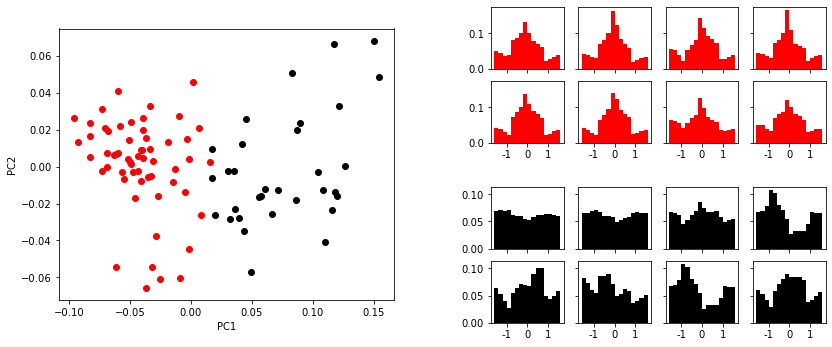

In [4]:
%matplotlib inline
from sklearn.decomposition import PCA
from neuropy import plotting

pca = PCA(n_components=2)
pca.fit(frate_norm)
projected = pca.fit_transform(frate_norm)

# figure = plotting.Fig()
# fig,gs = figure.draw(grid=(1,2))
# gs_ = figure.subplot2grid(gs[1],grid=(2,1))
fig = plt.figure(figsize=(12, 5))
subfigs = fig.subfigures(1, 2, wspace=0.7)
ax_pca = subfigs[0].subplots(1, 1)
ax_pca.set_xlabel("PC1")
ax_pca.set_ylabel("PC2")

hist_figs = subfigs[1].subfigures(2, 1)

colors = ["r", "k"]
for label in [0, 1]:
    indices = kmeans.labels_ == label
    ax_pca.scatter(projected[indices, 0], projected[indices, 1], c=colors[label])

    ind_subset = np.random.choice(np.where(indices)[0], 8)
    frate_subset = frate_norm[ind_subset]
    ax_hists = hist_figs[label].subplots(2, 4, sharex=True, sharey=True).reshape(-1)
    for i, f in enumerate(frate_subset):
        ax_hists[i].stairs(f, np.arange(-8, 9), color=colors[label], fill=True)
        ax_hists[i].set_xticks([-5, 0, 5])
        ax_hists[i].set_xticklabels([-1, 0, 1])

# fig.savefig(subjects.figpath_sd/'interneuron_ripple_classification.pdf')


<a id='ripple_rate'></a>
### Ripple rate first hour of SD vs NSD (or only restrict to 1h NREM sleep of NSD)
- One possiblity of faster decay of replay during sleep deprivation could be reduced ripple rate at the begining of POST. This may suggest that in order for cells to replay they need sufficient number/amount of exicitation to last for certain duration of time, so a lower ripple rate could interrupt this requirement.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from neuropy import plotting
import pandas as pd
from scipy import stats
import subjects

sessions = (
    subjects.sd.ratJday1
    +subjects.sd.ratKday1
    + subjects.sd.ratNday1
    + subjects.sd.ratSday3
    + subjects.sd.ratRday2
    + subjects.sd.ratUday4
    + subjects.sd.ratVday2

    + subjects.nsd.ratJday2
    + subjects.nsd.ratKday2
    + subjects.nsd.ratNday2
    + subjects.nsd.ratSday2
    + subjects.nsd.ratRday1
    + subjects.nsd.ratUday2
    + subjects.nsd.ratVday1
)

In [ ]:
rpl_rate = pd.DataFrame()
for sub, sess in enumerate(sessions):
    post = sess.paradigm["post"].flatten()
    w = 2 * 3600 # window size
    rpl_rate_sub = sess.ripple.time_slice(post[0], post[0] + w).n_epochs / w
    rpl_rate = rpl_rate.append(
        pd.DataFrame({"sub": sess.sub_name, "rpl_rate": [rpl_rate_sub], "grp": sess.tag})
    ).reset_index(drop=True)


In [ ]:
%matplotlib widget
import seaborn as sns

sns.lineplot(data=rpl_rate,x='grp',y='rpl_rate',hue='sub')

### Percentage of Cells firing during ripples

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from neuropy import plotting
import pandas as pd
from scipy import stats
import subjects

sessions = (
    subjects.sd.ratNday1
    + subjects.sd.ratSday3
    + subjects.sd.ratUday4

    + subjects.nsd.ratNday2
    + subjects.nsd.ratSday2
    + subjects.nsd.ratUday2
)

In [ ]:
for sub,sess in enumerate(sessions):
    post = sess.paradigm['post'].flatten()
    neurons = sess.neurons.get_neuron_type('pyr')
    rpls = sess.ripple.time_slice(post[0],post[0]+3600)
    modulation = neurons.get_modulation_in_epochs(rpls,n_bins=1).reshape(-1)
    firing_cells = np.where(modulation>0)[0]
    perc = len(firing_cells)/len(modulation)
    print(perc)

### Firing rate within and outside ripples during SD and NSD

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from neuropy import plotting
import pandas as pd
from scipy import stats
import subjects

sessions = (
    subjects.sd.ratNday1
    + subjects.sd.ratSday3
    + subjects.sd.ratUday4

    + subjects.nsd.ratNday2
    + subjects.nsd.ratSday2
    + subjects.nsd.ratUday2
)

In [ ]:
from neuropy.core import Epoch
from neuropy.utils.mathutil import min_max_scaler
frate_df = pd.DataFrame()
for sub, sess in enumerate(sessions):
    post = sess.paradigm["post"].flatten()
    neurons = sess.neurons.get_neuron_type("inter")
    starts = np.arange(8) * 3600 + post[0]

    frate_in, frate_out = [], []
    for start in starts:
        rpls = sess.ripple.time_slice(start, start + 3600)
        n_spikes_in = neurons.get_modulation_in_epochs(rpls, n_bins=1).reshape(-1)
        frate_in.append(n_spikes_in / rpls.durations.sum())

        out_rpls = Epoch.from_array(rpls.stops[:-1], rpls.starts[1:])
        n_spikes_out = neurons.get_modulation_in_epochs(out_rpls, n_bins=1).reshape(-1)
        frate_out.append(n_spikes_out / out_rpls.durations.sum())

    frate_sub = np.hstack((np.asarray(frate_in), np.asarray(frate_out))).T
    frate_sub = stats.zscore(frate_sub,axis=1)
    # frate_sub = min_max_scaler(frate_sub,axis=-1)
    # frate_sub = np.diff(frate_sub,axis=1)

    frate_sub_df = pd.DataFrame(frate_sub, columns=np.arange(1,9))
    frate_sub_df["rpl"] = ["in"] * len(neurons) + ["out"] * len(neurons)
    frate_sub_df["grp"] = sess.tag

    frate_df = frate_df.append(frate_sub_df).reset_index(drop=True)

frate_df = pd.melt(
    frate_df,
    id_vars=["rpl", "grp"],
    value_vars=np.arange(1,9),
    var_name="Zt time",
    value_name="frate",
    ignore_index=True,
)


In [ ]:
%matplotlib widget
import seaborn as sns

g = sns.catplot(
    data=frate_df,
    x="Zt time",
    y="frate",
    hue="rpl",
    col="grp",
    kind="bar",
    palette=["#69F0AE", "#FF80AB"],
    ci=95,
    capsize=0.1,
)
axes = g.axes[0]
# [ax.set_yscale('log') for ax in axes]


### PSTH around start of ripples during sleep deprivation

In [128]:
import matplotlib.pyplot as plt
import numpy as np
from neuropy import plotting
import pandas as pd
from scipy import stats
import subjects

sessions = (
    subjects.sd.ratNday1
    + subjects.sd.ratSday3
    + subjects.sd.ratUday4

    +subjects.nsd.ratNday2
    + subjects.nsd.ratSday2
    + subjects.nsd.ratUday2
)

In [142]:
from neuropy.core import Epoch

frate_around_rpl,grp_info = [],[]
for sub, sess in enumerate(sessions):
    post = sess.paradigm["post"].flatten()
    neurons = sess.neurons.get_neuron_type("pyr")
    grp_info.extend([sess.tag] * len(neurons))

    get_modulation = lambda e: neurons.get_modulation_in_epochs(e, 2)

    hour_modulation = []
    for t in [post[0], post[0] + 4 * 3600]:
        ripples = sess.ripple.time_slice(t, t + 3600)
        start, peak = ripples.to_dataframe()[["start", "peaktime"]].values.T
        start_peak_dur = peak - start
        epochs = Epoch.from_array(start - start_peak_dur, start + start_peak_dur)

        modulation = []
        for s in range(3):
            epoch_slices = epochs[s::3]  # [_[s::3] for _ in (pre_start, start_peak)]
            modulation.append(get_modulation(epoch_slices))
        hour_modulation.append(np.dstack(modulation).sum(axis=2)/ripples.durations.sum())

    frate_around_rpl.append(np.hstack(hour_modulation))

frate_around_rpl = np.vstack(frate_around_rpl)
# frate_norm = frate_around_rpl / np.sum(frate_around_rpl, axis=1, keepdims=True)
frate_norm = stats.zscore(frate_around_rpl, axis=1)

# bins = np.arange(-8, 9)
frate_rpl_df = pd.DataFrame(
    frate_around_rpl, columns=["pre_1h", "post_1h", "pre_5h", "post_5h"]
)
frate_rpl_df["grp"] = grp_info

# frate_session_df = pd.melt(
#     frate_session_df,
#     id_vars=["grp", "label"],
#     value_vars=time_bin,
#     var_name=["time"],
#     value_name="frate",
#     ignore_index=True,
# )


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
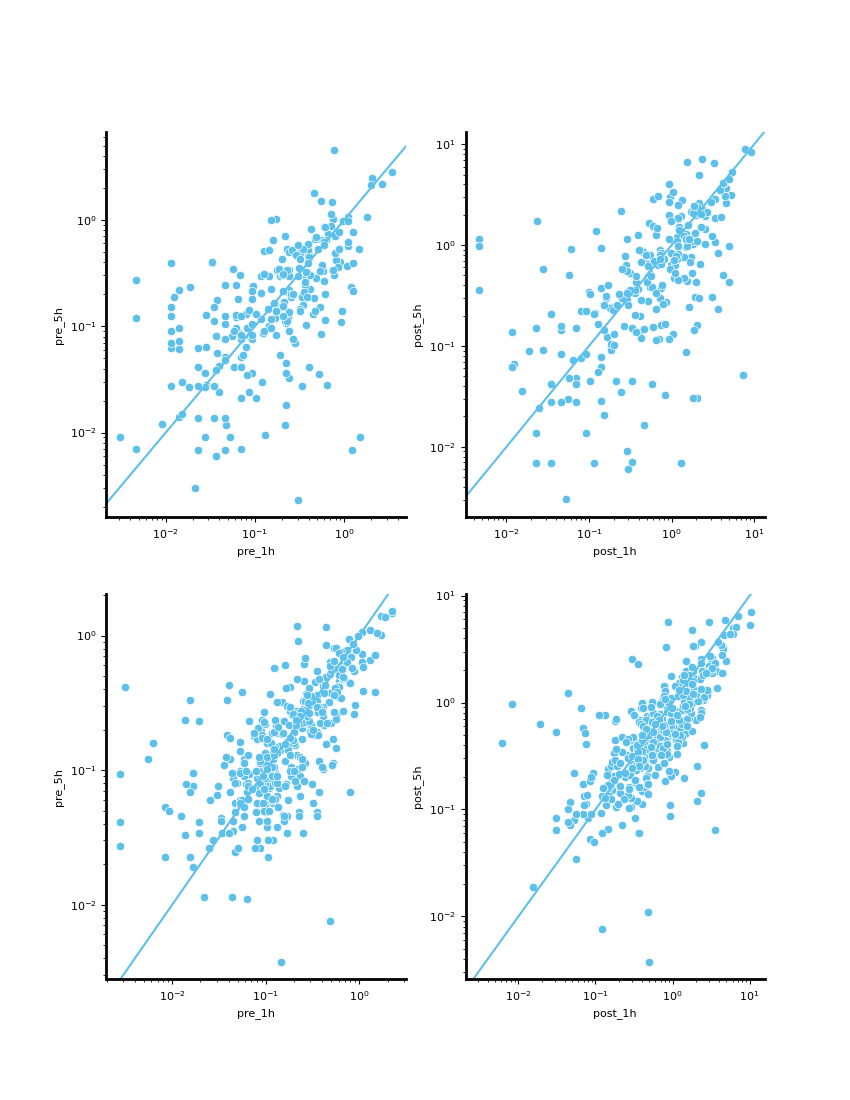

In [145]:
%matplotlib widget
import seaborn as sns

figure = plotting.Fig()
fig,gs = figure.draw(grid=(2,2))

for i,grp in enumerate(['sd','nsd']):
    df = frate_rpl_df[frate_rpl_df['grp']==grp]

    ax_pre = plt.subplot(gs[i,0])
    sns.scatterplot(data=df ,x='pre_1h',y='pre_5h',ax=ax_pre)
    ax_pre.set_xscale('log')
    ax_pre.set_yscale('log')
    ax_pre.axline((0,0),(1,1))


    ax_post = plt.subplot(gs[i,1])
    sns.scatterplot(data=df ,x='post_1h',y='post_5h',ax=ax_post)
    ax_post.set_xscale('log')
    ax_post.set_yscale('log')
    ax_post.axline((0,0),(1,1))
